## Segmentation

- 모델명 : xxxxx-seg

### 모델로딩 및 추론

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
model_path = 'models/yolov8m-seg.pt'
file_path = r'02_test_image_seg/beatles.jpg'
file_path = [r'02_test_image_seg/beatles.jpg', '02_test_image_seg/bus.jpg']

model_seg = YOLO(model_path)
results = model_seg(file_path, save=True, save_txt=True, line_width=1)
# results의 타입: List => 조회 이미지 개수별로 Results를 리스트에 묶어 반환.

100%|██████████████████████████████████████████████████████████████████████████████| 52.4M/52.4M [02:02<00:00, 449kB/s]



0: 640x640 5 persons, 10 cars, 1: 640x640 4 persons, 1 bus, 1 tie, 4944.8ms
Speed: 15.6ms preprocess, 2472.4ms inference, 70.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict
2 labels saved to runs\segment\predict\labels


In [3]:
len(results), type(results), type(results[0])

(2, list, ultralytics.engine.results.Results)

## Segmentation 추론결과 조회
- segmentation 추론 결과는 Boxes를 이용해 추론한 bounding box의 결과와 Masks를 이용해 분할된 mask 정보를 조회한다.
- **ultralytics.yolo.engine.results.Masks**
    - Segmentation 의 결과 type
    - Results.masks 로 조회한다.
    - 주요 속성, 메소드
        - shape: [object 개수, height, width]
            - height, width: mask image size
        - data: 결과 Tensor(3차원 배열) 반환. `0: 배경, 1: 물체` 를 원소로 가지는 결과 Tensor를 반환한다.
            - 픽셀별로 물체 인지 아닌 지를 표현하는 tensor를 반환
        - xy, xyn : mask의 bounding 좌표(경계선 좌표)를 물체별로 list에 담아서 반환한다.
            - 물체의 외곽선을 그리는 좌표들을 반환
            - xy: 실제 좌표, xyn: 이미지의 width/height 대비 비율
- **ultralytics.yolo.engine.results.Boxes**
     - Results.boxes로 조회
    - 주요 속성
        - shape: 결과 shape. (찾은 물체개수, 6)
        - boxes
            - 6: 좌상단 x, 좌상단 y, 우하단 x, 우하단 y, confidence score, label
        - xyxy
            - bounding box의 `좌상단 x, 좌상단 y, 우하단 x, 우하단 y` 좌표 반환
        - xyxyn
            - xyxy를 이미지 대비 비율로 반환
        - xywh
            - bounding box의 `center x, center y, 너비, 높이` 를 반환
        - xywhn
            - xywh를 이미지 대비 비율로 반환
        - cls: 찾은 물체의 label
        - conf: cls에 대한 confidence score (그 물체일 확률)
        - boxes
            - `x, y, x, y, conf, cls` tensor를 반환

In [4]:
# 첫번째이미지 추론결과
result = results[0]

In [5]:
cv2.imshow('result', result.plot())
cv2.waitKey()
cv2.destroyAllWindows()

In [6]:
## bbox 추론 결과들.
boxes = result.boxes
print(boxes.xyxy.shape)
print(boxes.cls.shape)
print(boxes.conf.shape)

torch.Size([15, 4])
torch.Size([15])
torch.Size([15])


In [7]:
## segmentation 추론 결과
masks = result.masks
print(type(masks))

<class 'ultralytics.engine.results.Masks'>


In [8]:
print(len(masks.xy), type(masks.xy), masks.xy[0].shape)  # masks.xy[0]: 첫번째 instance. (point개수, 2-xy좌표)

15 <class 'list'> (374, 2)


In [9]:
print(len(masks.xyn), type(masks.xyn), masks.xyn[0].shape)  # masks.xyn[0]: 첫번째 이미지. (point개수, 2) - width, height 대비 비율

15 <class 'list'> (374, 2)


In [10]:
a = np.zeros(result.orig_shape)

idx = masks.xy[0].astype('int')
y, x = idx[:,0], idx[:,1]   # y, x 좌표 나누기
a[x, y] = 255

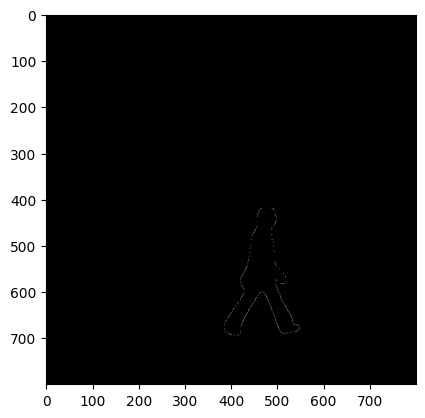

In [11]:
plt.imshow(a, cmap='gray')

In [12]:
# masks -> iterable
for m in masks:
    print(type(m), m.xy[0].shape)  #### 개별 object 조회결과를 가진 Masks 반환

<class 'ultralytics.engine.results.Masks'> (374, 2)
<class 'ultralytics.engine.results.Masks'> (298, 2)
<class 'ultralytics.engine.results.Masks'> (357, 2)
<class 'ultralytics.engine.results.Masks'> (315, 2)
<class 'ultralytics.engine.results.Masks'> (95, 2)
<class 'ultralytics.engine.results.Masks'> (12, 2)
<class 'ultralytics.engine.results.Masks'> (24, 2)
<class 'ultralytics.engine.results.Masks'> (29, 2)
<class 'ultralytics.engine.results.Masks'> (26, 2)
<class 'ultralytics.engine.results.Masks'> (60, 2)
<class 'ultralytics.engine.results.Masks'> (10, 2)
<class 'ultralytics.engine.results.Masks'> (11, 2)
<class 'ultralytics.engine.results.Masks'> (11, 2)
<class 'ultralytics.engine.results.Masks'> (21, 2)
<class 'ultralytics.engine.results.Masks'> (28, 2)


In [14]:
#### xy 를 이용해 찾은 대상 물체 경계 그리기.

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 모델 생성
model = YOLO("models/yolov8m-seg.pt")
# 추론
result = model("02_test_image_seg/bus.jpg")[0]
masks = result.masks

# 원본 이미지의 shape
shape = result.orig_shape

# 결과를 그릴 배열 - 원본이미지와 동일한 크기의 배열 생성
arr = np.zeros(shape, dtype='uint8')  # 엣지 형식으로 선만 그릴 것
instance_mask = np.zeros(shape, dtype="uint8")  # 물체만 추출하기 위한 mask
background_mask = np.full(shape, fill_value=255, dtype='uint8')  # 배경을 선택하기 위한 mask => blur 시킬 것.

# 찾은 instance들의 경계 좌표 조회들
xy_list = masks.xy  # 리스트: object 개수 (전체 object들에 대한 segment 결과)

############# 사람만 따기
for i in range(len(masks)):
    if result.boxes[i].cls.item()==0: # class가 Person이면 (coco dataset에서 0: Person)
        coords = xy_list[i].astype('int32')
        arr = cv2.polylines(arr, [coords], isClosed=True, color=(255,255,255), thickness=2) # 선그리기
        cv2.fillPoly(instance_mask, [coords], 255)                                          # 선 안쪽을 255로 채우기
        cv2.fillPoly(background_mask, [coords], 0)                                          # 선 안쪽을 0으로 채우기

        result_img = cv2.add(result.orig_img, # 원본 이미지 배열
                             cv2.cvtColor(instance_mask, cv2.COLOR_GRAY2BGR) # 대상
                            )
        # cv2.add(배열1, 배열2) 배열1(uint8) + 배열2(uint8): 결과가 0 ~ 255 범위 밖이면 0, 255에 맞춘다. -> satu

cv2.imshow("frame1", arr)
# cv2.waitKey()
cv2.imshow("frame2", instance_mask)
# cv2.waitKey()
cv2.imshow("frame3", background_mask)
# cv2.waitKey()
cv2.imshow("frame4", result_img)
cv2.waitKey()

cv2.destroyAllWindows()


image 1/1 C:\Users\Playdata\Downloads\Playdata_\08_computervision\실습\02_test_image_seg\bus.jpg: 640x480 4 persons, 1 bus, 1 tie, 1645.6ms
Speed: 0.0ms preprocess, 1645.6ms inference, 31.2ms postprocess per image at shape (1, 3, 640, 480)


# custom dataset training

- custom dataset training은 object detection과 동일
- custom dataset: https://universe.roboflow.com/angelo-maglasang-vuuq3/crack_flip_rotate/dataset/1


1. labeling
    - 이미지 파일당 한개의 txt
    - 한줄에 하나의 instance에 대한 설정. 
    ```
    label x1 y1 x2 y2 .....  # x,y가 polygon 의 좌표
    ```
2. 학습관련 설정
    - yaml 파일
        - train: train set의 경로
        - val: validation set의 경로
        - test: test set의 경로
        - nc: 클래스개수
        - names: [클래스 이름]

In [19]:
ft_model = YOLO('models/yolov8n-seg.pt') # pretrained 모델의 경로 => fine tuning
ft_model.train(data='C:/Users/Playdata/Downloads/Playdata_/08_computervision/실습/crack_flip_rotate.v1i.yolov8/data.yaml', # 데이터셋 설정파일
               epochs=100, 
               batch=32,  # default: 16
               imgsz=640, # default: 640
               patience=30, # 조기종료 조건. 
               optimizer='Adam'
              )

New https://pypi.org/project/ultralytics/8.1.14 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.13 🚀 Python-3.10.13 torch-2.2.0+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=segment, mode=train, model=models/yolov8n-seg.pt, data=C:/Users/Playdata/Downloads/Playdata_/08_computervision/실습/crack_flip_rotate.v1i.yolov8/data.yaml, epochs=100, time=None, patience=30, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

100%|████████████████████████████████████████████████████████████████████████████████| 755k/755k [00:05<00:00, 151kB/s]



Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning C:\Users\Playdata\Downloads\Playdata_\08_computervision\실습\crack_flip_rotate.v1i.yolov8\train\labels.


train: New cache created: C:\Users\Playdata\Downloads\Playdata_\08_computervision\실습\crack_flip_rotate.v1i.yolov8\train\labels.cache


val: Scanning C:\Users\Playdata\Downloads\Playdata_\08_computervision\실습\crack_flip_rotate.v1i.yolov8\valid\labels...

val: New cache created: C:\Users\Playdata\Downloads\Playdata_\08_computervision\실습\crack_flip_rotate.v1i.yolov8\valid\labels.cache


Plotting labels to runs\segment\train3\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.937      3.596      3.226      1.765         67        640:  32%|███▏      | 6/19 [05:59<


KeyboardInterrupt: 

In [17]:
###### 추론

from glob import glob
from ultralytics import YOLO
best_model_path = 'crack_model/best.pt'
image_files_path = glob('02_test_image_seg/crack*.jpg')
image_files_path

['02_test_image_seg\\crack0.jpg',
 '02_test_image_seg\\crack1.jpg',
 '02_test_image_seg\\crack2.jpg',
 '02_test_image_seg\\crack3.jpg',
 '02_test_image_seg\\crack4.jpg',
 '02_test_image_seg\\crack5.jpg',
 '02_test_image_seg\\crack6.jpg',
 '02_test_image_seg\\crack7.jpg',
 '02_test_image_seg\\crack8.jpg',
 '02_test_image_seg\\crack9.jpg']

In [18]:
best_model = YOLO(best_model_path)

results = best_model(image_files_path, save=True, save_txt=True)[0]


0: 640x640 1 crack, 1: 640x640 1 crack, 2: 640x640 1 crack, 3: 640x640 2 cracks, 4: 640x640 1 crack, 5: 640x640 2 cracks, 6: 640x640 1 crack, 7: 640x640 4 cracks, 8: 640x640 2 cracks, 9: 640x640 1 crack, 4861.6ms
Speed: 9.5ms preprocess, 486.2ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict2
10 labels saved to runs\segment\predict2\labels
